In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
plt.style.use('default')
#plt.rcParams['text.usetex'] = True
# plt.rc('figure',facecolor=(0,0,0,0)) # Set transparent background
%config InlineBackend.figure_format='retina'
%matplotlib qt 
%matplotlib inline 

In [2]:
import quflowMHD as qf

# Generate random vorticity and plot it

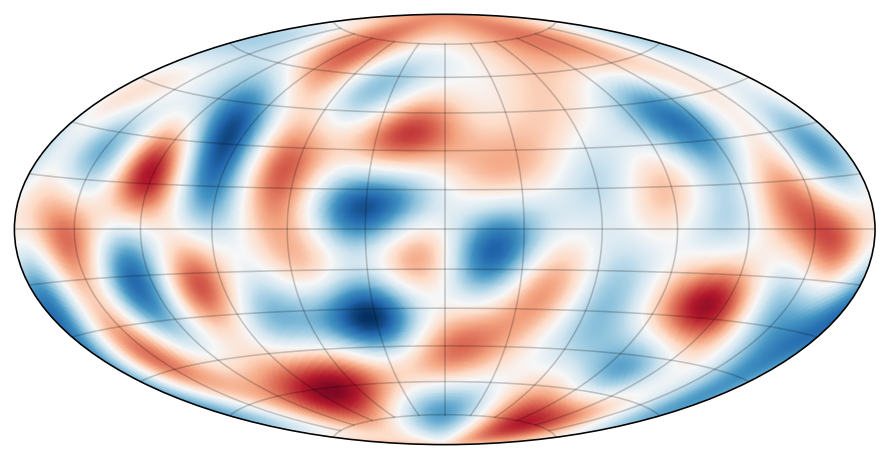

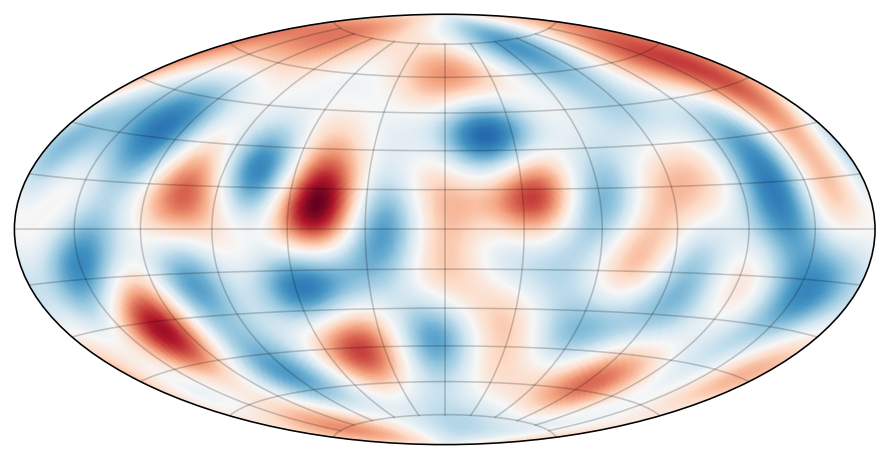

In [3]:
lmax = 10  # How many spherical harmonics (SH) coefficients to include
np.random.seed(42)  # For reproducability
omega0 = np.random.randn(lmax**2)  # Array with SH coefficients
omega0[0] = 0
omega0[1] = 0
omega0[2] = 0
omega0[3] = 0
magn0 = 1/1000*np.random.randn(lmax**2)
qf.plot2(omega0,projection='hammer', N=512)  # Plot command
qf.plot2(magn0,projection='hammer', N=512)  # Plot command

# Simulation of MHD equations on the sphere

In vorticity formulation, MHD equations are
\begin{equation}
\label{MHDvort}
\left\{
\begin{aligned}
&\dot\omega=\left\{\omega,\psi\right\}+\left\{\theta,\beta\right\}, \\
&\dot\theta=\left\{\theta,\psi\right\},\\
&\omega=\Delta\psi,\\
&\beta=\Delta\theta,
\end{aligned}
\right.
\end{equation}
where $\omega$ is the vorticity function, $\beta$ is the magnetic vorticity, $\psi$ is the stream function, $\theta$ is the magnetic stream function. The quantized MHD equations are 
\begin{equation}
\label{qMHD}
\left\{
\begin{aligned}
&\dot W=[W,\Delta^{-1}_{N}W]+[\Theta,\Delta_{N}\Theta], \\
&\\
&\dot\Theta=[\Theta,\Delta^{-1}_{N}W],
\end{aligned}
\right.
\end{equation}
where $W,\Theta\in\mathfrak{su}(N)$.

### ISOMP method using fixed point iterations
The method is
\begin{equation}
\label{MHDmethod1}
\begin{aligned}
W_{n}&=\tilde W-\frac{h}{2}[\tilde W,M_{1}]-\frac{h}{2}[\tilde\Theta,M_{2}]-\frac{h^{2}}{4}M_{1}\tilde W M_{1}+\\
&+\frac{h^{2}}{8}M_{1}[M_{2},\tilde Z]+\frac{h^{2}}{8}[M_{2},\tilde{Z}^{\dag}]M_{1},\\
Z_{n}&=\left(I+\frac{h}{2}M_{1}\right)\tilde Z\left(I+\frac{h}{2}M_{1}\right)^{-1},\\
\Theta_{n}&=\frac{1}{2}(Z_{n}-Z_{n}^{\dag}),
\end{aligned}
\end{equation}
\begin{equation}
\label{MHDmethod2}
\begin{aligned}
W_{n+1}&=\tilde W+\frac{h}{2}[\tilde W,M_{1}]+\frac{h}{2}[\tilde\Theta,M_{2}]-\frac{h^{2}}{4}M_{1}\tilde W M_{1}+\\
&+\frac{h^{2}}{8}M_{1}[M_{2},\tilde Z]+\frac{h^{2}}{8}[M_{2},\tilde Z^{\dag}]M_{1},\\
Z_{n+1}&=\left(I-\frac{h}{2}M_{1}\right)\tilde Z\left(I-\frac{h}{2}M_{1}\right)^{-1},\\
\Theta_{n+1}&=\frac{1}{2}(Z_{n+1}-Z_{n+1}^{\dag}),
\end{aligned}
\end{equation}
where $M_{1}=\Delta_{N}^{-1}\tilde W$, $M_{2}=\Delta_{N}\tilde\Theta$, $I$ is the identity matrix.

## Create initial conditions

In [4]:
N = 128 # Size of matrices
W0 = qf.shr2mat(omega0, N=N)  # Convert SH coefficients to matrix
theta0 = qf.shr2mat(magn0, N=N) 
#P0 = qf.solve_poisson(W0)
#lambda0 = np.linalg.norm(theta0)**2
lambda0 = np.sort(np.imag(np.linalg.eig(theta0)[0]))[0]
crosshel0 = np.real(np.trace(W0@theta0))
psi0 = qf.laplacian.solve_poisson(W0)
beta0 = qf.laplacian.laplace(theta0)
ham0 = np.real(1/2*np.trace(W0@psi0+theta0@beta0))
print(lambda0)
print(ham0)

-0.0017178013085458797
1.386826266264817


## Run simulation

In [5]:
# filename = "my_sim_N_{}_isonewton.hdf5".format(str(N))
filename = "my_sim_N_{}_isofix.hdf5".format(str(N))
# filename = "my_sim_N_{}_isonewton.hdf5".format(str(N))
# filename = "my_sim_N_{}_heun.hdf5".format(str(N))
#time = 400.0 # in second
#inner_time = 20 # in seconds
#qstepsize = 2.5 # in qtime
time = 40 # in second
inner_time = 0.5 # in seconds
qstepsize = 0.1# in qtime

In [6]:
# Run this if you want to remove the existing hdf5 file
%rm $filename

In [7]:
dt = qf.qtime2seconds(qstepsize, N)
print("The physical stepsize is {:.3e} seconds.".format(dt))
print("{} steps per output, in total {} steps.".format(round(inner_time/dt), round(time/dt)))

The physical stepsize is 4.896e-04 seconds.
1021 steps per output, in total 81703 steps.


In [8]:

# Callback data object
mysim = qf.QuData(filename)

# Save initial conditions if file does not exist already, otherwise load from last step
try:
    f = h5py.File(filename, "r")
except IOError or KeyError:
    W = W0.copy()
    theta = theta0.copy()
    mysim(W,theta,0.0)
else:
    W = qf.shr2mat(f['state'][-1,:], N=N)
    assert W.shape[0] == N, "Looks like the saved data use N = {} whereas you specified N = {}.".format(W.shape[0], N)
    f.close()

# Select solver
if "isonewton" in filename:
    solver = qf.isomp
elif "isofix" in filename:
    solver = qf.isomp_fixedpoint
elif "heun" in filename:
    solver = qf.heun
elif "rk4" in filename:
    solver = qf.rk4
else:
    solver = qf.rk4

# Run simulation

qf.solve(W,theta,qstepsize=qstepsize, time=time, inner_time=inner_time, callback=mysim,
         method=solver, method_kwargs={"verbatim":True, "maxit":1500, "tol":1e-8})

# Flush cache data
mysim.flush()

  0%|          | 0/81703 [00:00<?, ? steps/s]

Time of execution: 1.7368123014767964 min
Iteration 1 finished. 
Time of execution: 1.925794283548991 min
Iteration 2 finished. 
Time of execution: 1.8950581312179566 min
Iteration 3 finished. 
Time of execution: 1.890391500790914 min
Iteration 4 finished. 
Time of execution: 1.9127742846806843 min
Iteration 5 finished. 
Time of execution: 1.897787086168925 min
Iteration 6 finished. 
Time of execution: 1.8970770160357158 min
Iteration 7 finished. 
Time of execution: 1.8978665987650554 min
Iteration 8 finished. 
Time of execution: 1.9094212333361307 min
Iteration 9 finished. 
Time of execution: 1.8812950015068055 min
Iteration 10 finished. 
Time of execution: 1.8957762877146402 min
Iteration 11 finished. 
Time of execution: 1.9130456686019897 min
Iteration 12 finished. 
Time of execution: 1.8890706181526185 min
Iteration 13 finished. 
Time of execution: 1.8932062983512878 min
Iteration 14 finished. 
Time of execution: 1.8838476618131001 min
Iteration 15 finished. 
Time of execution: 1.8

60.2694113555694


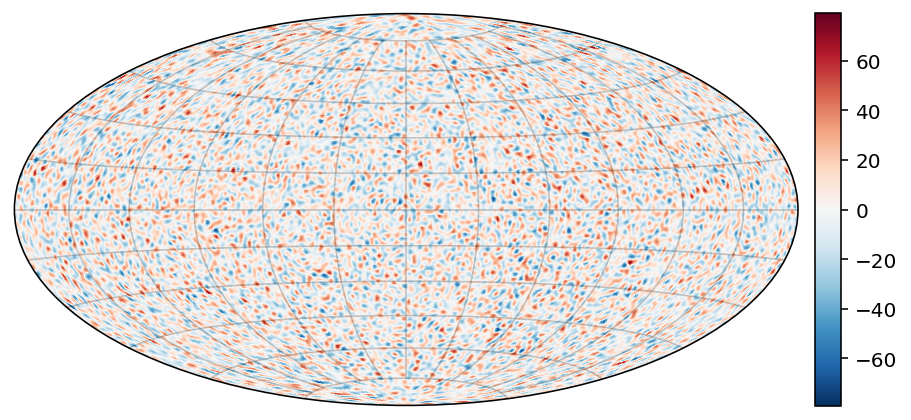

In [9]:
# Plot last state
#filename =  "my_sim_N_128.hdf5"
with h5py.File(filename, 'r') as data:
    #print(data['state'][2])
    omega = data['stateW'][40]
    print(np.linalg.norm(omega))
    #print(omega)
    qf.plot2(omega, projection='hammer', N=512, colorbar=True)
    plt.savefig("state_W_40.eps")

82


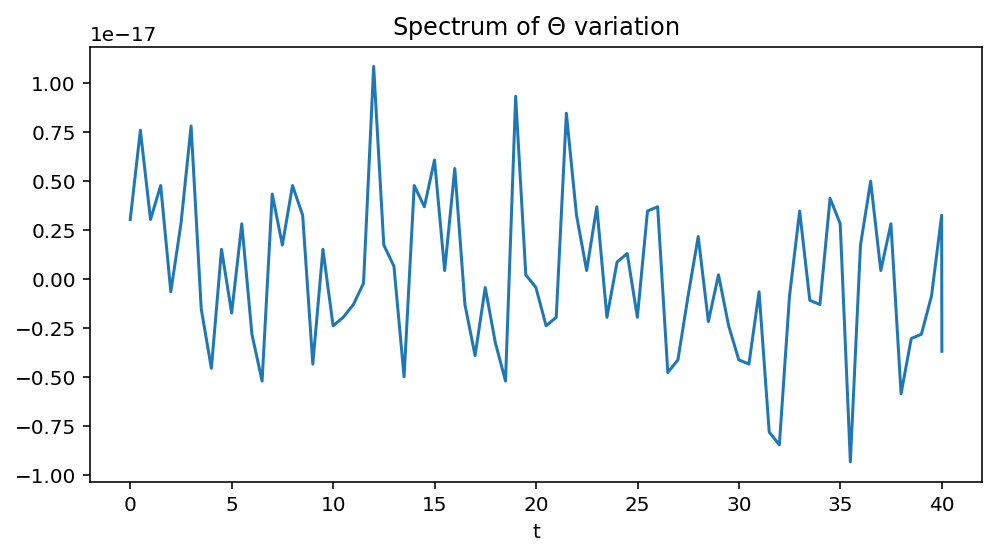

In [10]:
#filename = "my_sim_N_5_isofix.hdf5"
#N = 5
with h5py.File(filename, 'r') as data:
    casimir = np.zeros(data['stateTheta'].shape[0], dtype=np.float64)
    tphys = np.zeros(data['time'].shape[0], dtype=np.float64)
    print(data['stateTheta'].shape[0])
    for k in range(data['stateTheta'].shape[0]):
        omega = data['stateTheta'][k]
        mat_omega = qf.shr2mat(omega, N=N)
        tphys[k] = data['time'][k]
        casimir[k]= np.sort(np.imag(np.linalg.eig(mat_omega)[0]))[0]-lambda0
    casimir = np.asarray(casimir)
    fig1 = plt.figure(figsize=(8,4))
    plt.plot(tphys,casimir)
    plt.xlabel("t")
    plt.title(r"Spectrum of $\Theta$ variation")
    plt.savefig("cas.eps")

82


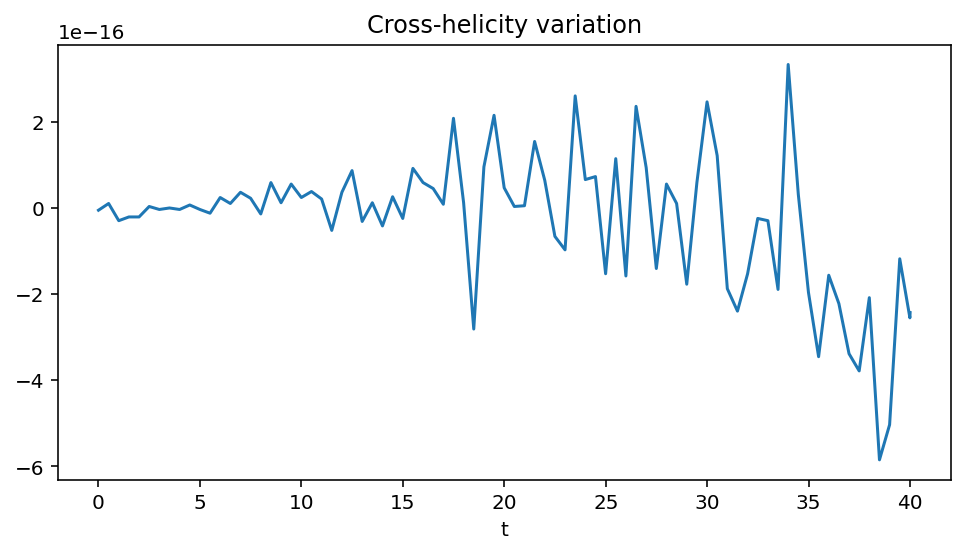

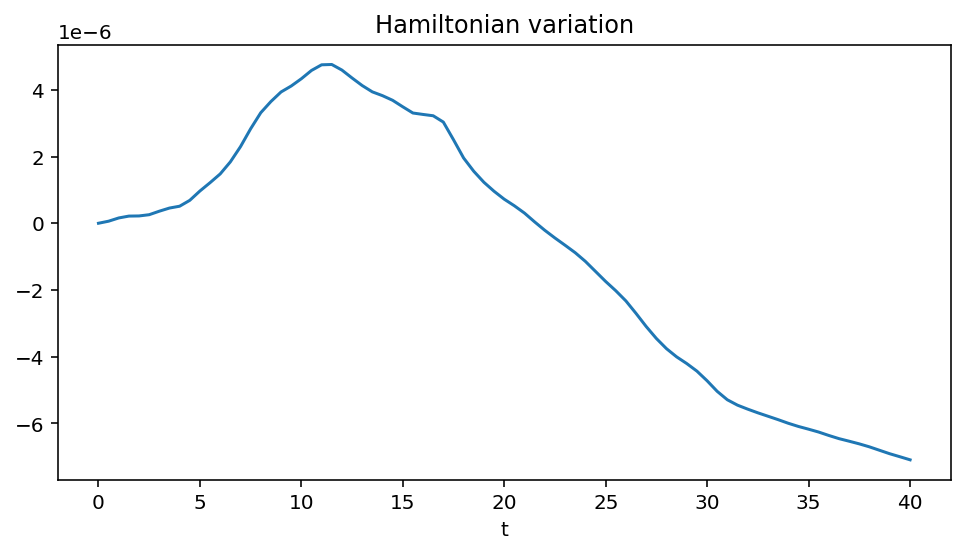

In [11]:
with h5py.File(filename, 'r') as data:
    crosshel = np.zeros(data['stateTheta'].shape[0], dtype=np.float64)
    ham = np.zeros(data['stateTheta'].shape[0], dtype=np.float64)
    tphys = np.zeros(data['time'].shape[0], dtype=np.float64)
    print(data['stateTheta'].shape[0])
    for k in range(data['stateTheta'].shape[0]):
        omega = data['stateW'][k]
        magn = data['stateTheta'][k]
        mat_omega = qf.shr2mat(omega, N=N)
        mat_psi = qf.laplacian.solve_poisson(mat_omega)
        mat_magn = qf.shr2mat(magn, N=N)
        mat_beta = qf.laplacian.laplace(mat_magn)
        tphys[k] = data['time'][k]
        crosshel[k]= np.real(np.trace(mat_omega@mat_magn))-crosshel0
        ham[k] = np.real(1/2*np.trace(mat_omega@mat_psi+mat_magn@mat_beta))-ham0
    crosshel = np.asarray(crosshel)
    ham = np.asarray(ham)
    fig1 = plt.figure(figsize=(8,4))
    plt.plot(tphys,crosshel)
    plt.xlabel("t")
    plt.title("Cross-helicity variation")
    plt.savefig("crosshel.eps")
    fig2 = plt.figure(figsize=(8,4))
    plt.plot(tphys,ham)
    plt.xlabel("t")
    plt.title("Hamiltonian variation")
    plt.savefig("ham.eps")

## Animate the results

In [12]:
with h5py.File(filename, 'r') as data:
    anim = qf.create_animation2(filename.replace(".hdf5",".mp4"), data['stateTheta'], projection='mollweide', N=512)
anim

  0%|          | 0/82 [00:00<?, ? frames/s]

In [16]:
#filename =  "my_sim_N_128_isofix.hdf5"
#with h5py.File(filename, 'r') as data:
#    anim = qf.create_animation2(filename.replace(".hdf5",".mp4"), data['stateTheta'], projection='mollweide', N=512)
#anim

In [13]:
with h5py.File(filename, 'r') as data:
    anim1 = qf.create_animation2(filename.replace(".hdf5",".mp4"), data['stateW'], projection='mollweide', N=512)
anim1

  0%|          | 0/82 [00:00<?, ? frames/s]